# Primordial non-Gaussianity examples

In this notebook we will show how to perform PNG fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 61)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
pk_prim = cosmo.get_primordial(mode='scalar').pk_interpolator()(k)
pphi_prim = 9 / 25 * 2 * np.pi**2 / k**3 * pk_prim / cosmo.h**3
alpha = 1. / (pk / pphi_prim)**0.5

fnl = 100.
# PNG response of dark matter halos in spherical collapse
b1 = 2.
bphi = 2. * 1.686 * (b1 - 1.)
b = b1 + bphi * fnl * alpha
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

## PNG likelihood

In [2]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, PNGTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import ObservedTracerPowerSpectrumMultipoles
from desilike.likelihoods import GaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
# fnl_loc is degenerate with PNG bias bphi. Parameterization is controlled by "mode".
# - "b-p": bphi = 2 * 1.686 * (b1 - p), p as a parameter
# - "bphi": bphi as a parameter
# - "bfnl_loc": bfnl_loc = bphi * fnl_loc as a parameter'
# Here we choose b-p parameterization
theory = PNGTracerPowerSpectrumMultipoles(template=template, mode='b-p')
theory.params['p'].fixed = True  # not fixing p biases fnl_loc posterior
# In our mock data sigmas = 0, so just fix it to 0
#theory.params['sigmas'].value = 0.
#theory.params['sigmas'].fixed = True
observable = ObservedTracerPowerSpectrumMultipoles(data=mean, mocks=mocks,
                                                   klim={0: [0.005, 0.2], 2: [0.005, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                   kstep=0.005, theory=theory)
likelihood = GaussianLikelihood(observables=[observable], scale_covariance=True)

setup_logging()
likelihood()  # just to initialize

[000000.14] [0/1] 12-02 18:38  GaussianLikelihood        INFO     Covariance matrix with 78 points built from 1000 observations.
[000000.14] [0/1] 12-02 18:38  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9209.
[000000.75] [0/1] 12-02 18:38  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.75] [0/1] 12-02 18:38  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.75] [0/1] 12-02 18:38  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.78] [0/1] 12-02 18:38  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.78] [0/1] 12-02 18:38  absl                      WARNING  No GPU/TPU found, falling back to CP

-6475.374693765397

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000000.98] [0/1] 12-02 18:38  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].


In [4]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+-------------+--------+---------+--------+
| chi2 = 0.05 | varied | bestfit | error  |
+-------------+--------+---------+--------+
|   fnl_loc   |  True  |  100.0  |  1.7   |
|     b1      |  True  | 1.9999  | 0.0011 |
|     sn0     |  True  |   0.6   |  4.1   |
|   sigmas    |  True  |  0.04   |  0.11  |
+-------------+--------+---------+--------+


## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [5]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000007.36] [0/1] 12-02 18:38  ZeusSampler               INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].
[000007.43] [0/1] 12-02 18:38  root                      INFO     Initialising ensemble of 10 walkers...
[000193.05] [0/1] 12-02 18:41  ZeusSampler               INFO     Diagnostics:
[000193.06] [0/1] 12-02 18:41  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.247; not < 0.04.
[000193.06] [0/1] 12-02 18:41  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0445.
[000193.07] [0/1] 12-02 18:41  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is -0.00226.
[000193.08] [0/1] 12-02 18:41  ZeusSampler               INFO     - max Geweke is 0.274.
[000193.08] [0/1] 12-02 18:41  ZeusSampler               INFO     - Geweke p-value is 0.0381.
[000193.09] [0/1] 12-02 18:41  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 15.1.
[000193.11] [0/1] 12-02 18:41  root      

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000310.73] [0/1] 12-02 18:43  ZeusSampler               INFO     Diagnostics:
[000310.74] [0/1] 12-02 18:43  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.206; not < 0.04.
[000310.75] [0/1] 12-02 18:43  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.122.
[000310.76] [0/1] 12-02 18:43  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is -0.000731.
[000310.77] [0/1] 12-02 18:43  ZeusSampler               INFO     - max Geweke is 0.305.
[000310.77] [0/1] 12-02 18:43  ZeusSampler               INFO     - Geweke p-value is 0.00756.
[000310.78] [0/1] 12-02 18:43  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) is 23.1.
[000310.78] [0/1] 12-02 18:43  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.474.
[000310.80] [0/1] 12-02 18:43  root                      INFO     Initialising ensemble of 10 walkers...
[000360.05] [0/1] 12-02 18:44  Zeu

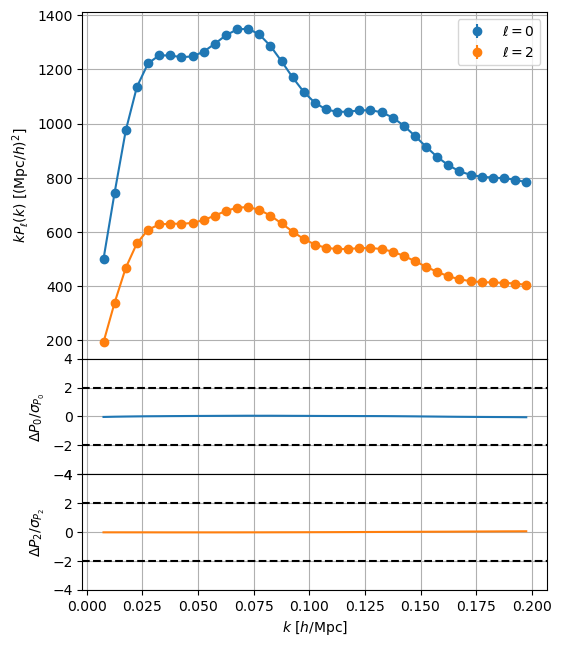

In [6]:
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [7]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+---------+---------+---------+---------+-----------------+-----------------+
|         | argmax  |  mean   | median  |   std   | quantile:1sigma | interval:1sigma |
+---------+---------+---------+---------+---------+-----------------+-----------------+
| fnl_loc |  100.1  |  99.8   |  99.8   |   1.5   |    -1.6/+1.5    |    -1.6/+1.5    |
|   b1    | 1.99988 | 2.00016 | 2.00014 | 0.00086 | -8.4e-4/+8.4e-4 | -8.7e-4/+8.0e-4 |
|   sn0   |   0.8   |  -0.2   |  -0.2   |   3.7   |    -3.7/+3.6    |    -3.7/+3.5    |
| sigmas  |  0.049  |  0.063  |  0.060  |  0.039  |  -0.044/+0.043  |  -0.062/+0.020  |
+---------+---------+---------+---------+---------+-----------------+-----------------+


[000557.15] [0/1] 12-02 18:47  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


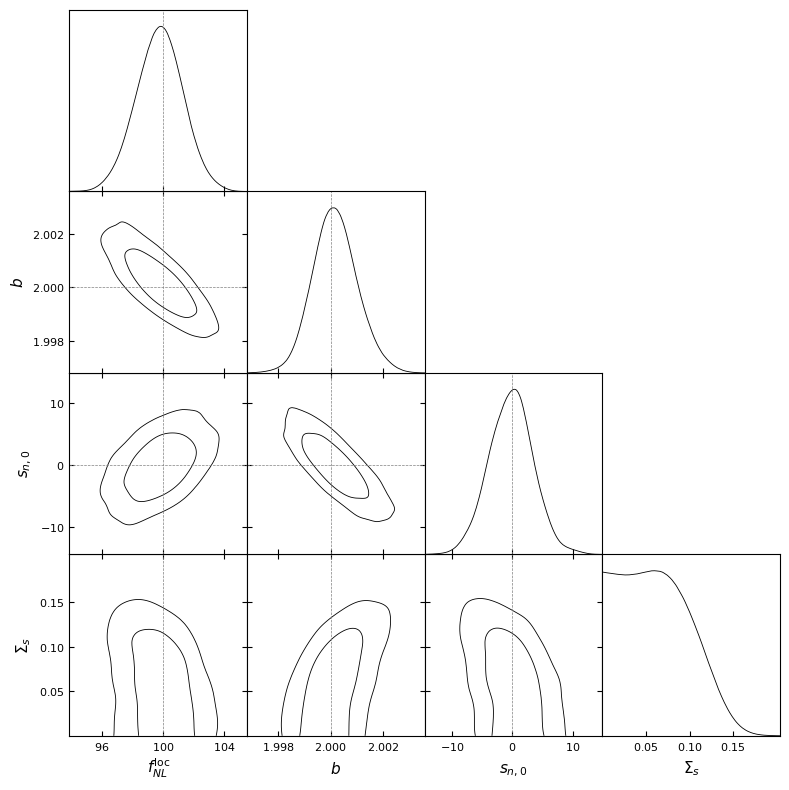

In [8]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'fnl_loc': 100., 'b1': b1, 'sn0': 0., 'sigmas': 0.})